# Homework 7
In this homework, we will implement a simplified version of object detection process. Note that the tests on the notebook are not comprehensive, autograder will contain more tests.

In [1]:
from __future__ import print_function
import random 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
from skimage.feature import hog
from skimage import data, color, exposure
from skimage.transform import rescale, resize, downscale_local_mean
import glob, os
import fnmatch
import time
import math

import warnings
warnings.filterwarnings('ignore')

from detection import *
from util import *

# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Part 1: Hog Representation (10 points)

In this section, we will compute the average hog representation of human faces.<br>
There are 31 aligned face images provided in the `\face` folder. They are all aligned and have the same size. We will get an average face from these images and compute a hog feature representation for the averaged face. <br>
Use the hog function provided by skimage library, and implement a hog representation of objects.
Implement **`hog_feature`** function in `detection.py`

(40500,) (218, 178)


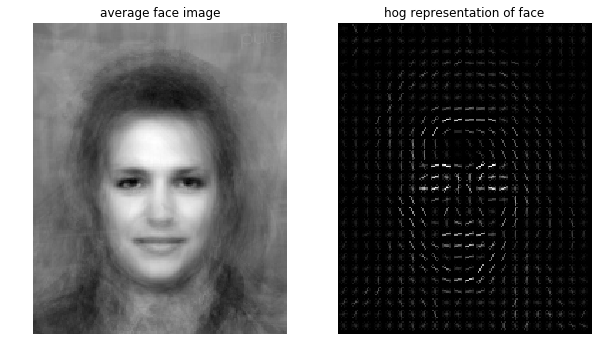

In [2]:
image_paths = fnmatch.filter(os.listdir('./face'), '*.jpg')
list.sort(image_paths)
n = len(image_paths)
face_shape = io.imread('./face/'+image_paths[0], as_grey=True).shape
avg_face= np.zeros((face_shape))
for i,image_path in enumerate(image_paths):
    image = io.imread('./face/'+image_path, as_grey=True)
    avg_face = np.asarray(image)+np.asarray(avg_face)
avg_face = avg_face/n

(face_feature, face_hog) = hog_feature(avg_face)
print(face_feature.shape, face_hog.shape)
plt.subplot(1,2,1)
plt.imshow(avg_face)
plt.axis('off')
plt.title('average face image')

plt.subplot(1,2,2)
plt.imshow(face_hog)
plt.title('hog representation of face')
plt.axis('off')

plt.show()


# Part 2: Sliding Window (30 points)
Implement **`sliding_window`** function to have windows slide across an image with a specific window size. The window slides through the image and check if an object is detected with a high score at every location. These scores will generate a response map and you will be able to find the location of the window with the highest hog score. 


(123039,) (270, 408)
(218, 178)


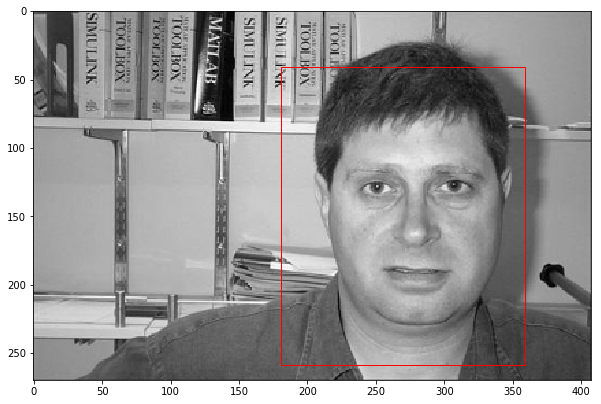

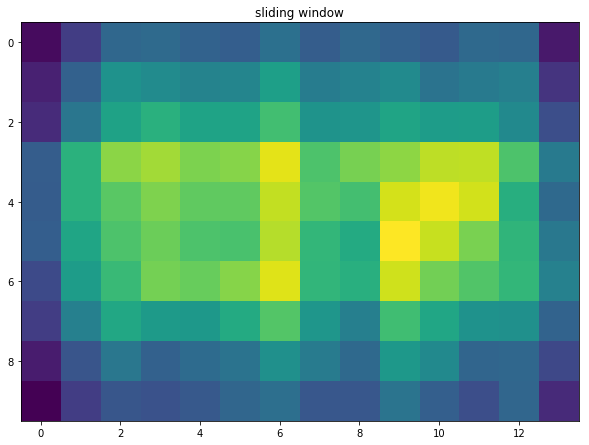

In [3]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_grey=True)
image = rescale(image, 0.8)

(hogFeature, hogImage) = hog_feature(image)
print(hogFeature.shape , hogImage.shape)
print(face_shape)
(winH, winW) = face_shape
(score, r, c, response_map) = sliding_window(image, face_feature, stepSize=30, windowSize=face_shape)
crop = image[r:r+winH, c:c+winW]

fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle((c,r),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(response_map,cmap='viridis', interpolation='nearest')
plt.title('sliding window')
plt.show()



Sliding window successfully found the human face in the above example. However, in the cell below, we are only changing the scale of the image, and you can see that sliding window does not work once the scale of the image is changed. 

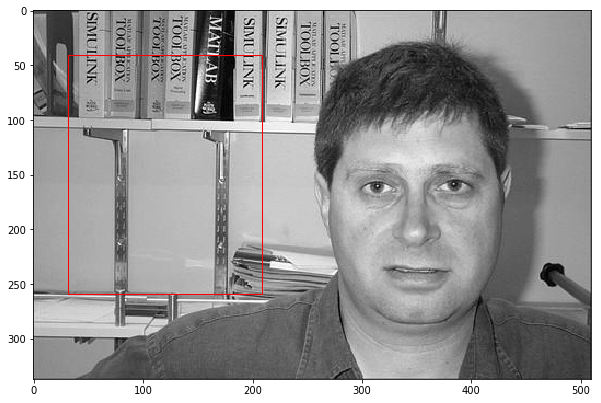

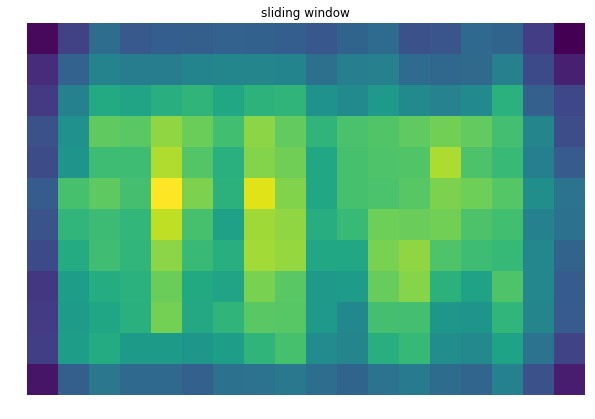

In [4]:
image_path = 'image_0001.jpg'
image = io.imread(image_path, as_grey=True)
image = rescale(image, 1.0)


(winH, winW) = face_shape
(score, r, c, max_response_map) = sliding_window(image, face_feature, stepSize=30, windowSize=face_shape)

crop = image[r:r+winH, c:c+winW]

fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle((c,r),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map,cmap='viridis', interpolation='nearest')
plt.title('sliding window')
plt.axis('off')
plt.show()


# Part 3: Image Pyramids (30 points)
In order to make sliding window work for different scales of images, you need to implement image pyramids where you resize the image to different scales and run the sliding window method on each resized image. This way you scale the objects and can detect both small and large objects. 


###  3.1 Image Pyramid (10 points)

Implement **`pyramid`** function in `detection.py`, this will create pyramid of images at different scales. Run the following code, and you will see the shape of the original image gets smaller until it reaches a minimum size.


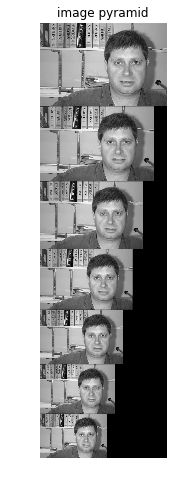

In [5]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_grey=True)
image = rescale(image, 1.2)

images = pyramid(image, scale = 0.9)
sum_r = 0
sum_c = 0
for i,result in enumerate(images):
    (scale, image) = result
    if (i==0):
        sum_c = image.shape[1]
    sum_r+=image.shape[0]

composite_image = np.zeros((sum_r, sum_c))

pointer = 0
for i, result in enumerate(images):
    (scale, image) = result   
    composite_image[pointer:pointer+image.shape[0], :image.shape[1]] = image
    pointer+= image.shape[0]
    
plt.imshow(composite_image)
plt.axis('off')
plt.title('image pyramid')
plt.show()


###  3.2 Pyramid Score (20 points)

After getting the image pyramid, we will run sliding window on all the images to find a place that gets the highest score. Implement **`pyramid_score`** function in `detection.py`. It will return the highest score and its related information in the image pyramids.

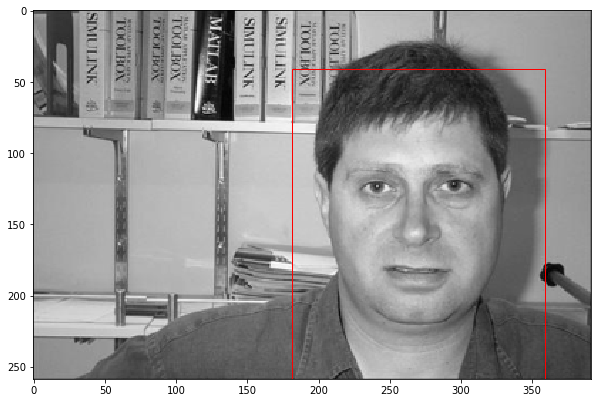

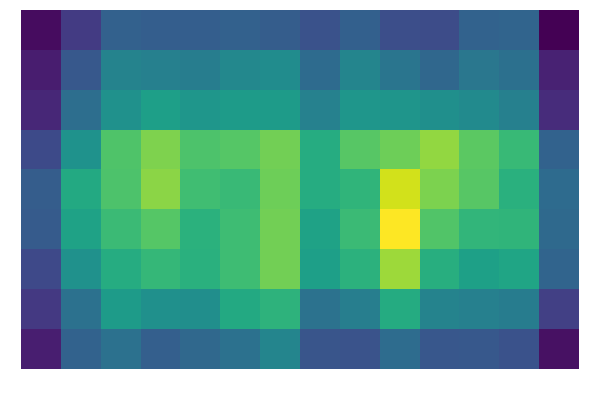

In [6]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_grey=True)
image = rescale(image, 1.2)

(winH, winW) = face_shape
max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
        (image, face_feature, face_shape, stepSize = 30, scale=0.8)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map, cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()

From the above example, we can see that image pyramid has fixed the problem of scaling. Then in the example below, we will try another image and implement deformable part model.

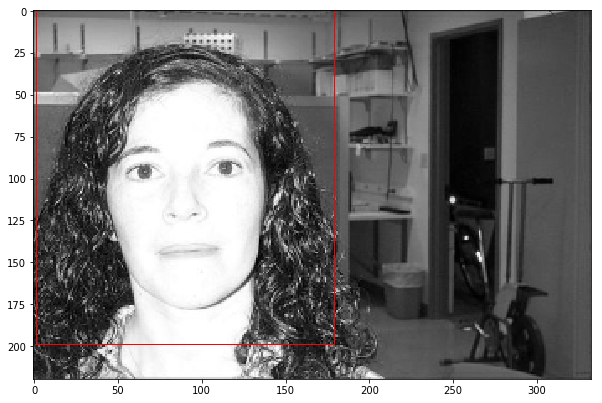

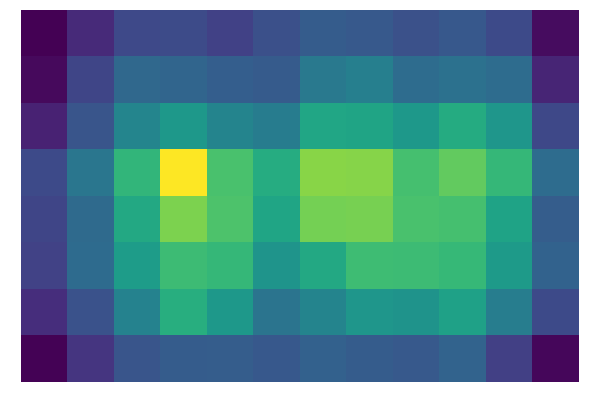

In [7]:
image_path = 'image_0338.jpg'
image = io.imread(image_path, as_grey=True)
image = rescale(image, 1.0)

(winH, winW) = face_shape

max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
    (image, face_feature, face_shape, stepSize = 30, scale=0.8)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()
    

# Part 4: Deformable Parts Detection
In order to solve the problem above, you will implement deformable parts model in this section, and apply it on human faces. <br>
The first step is to get a detector for each part of the face, including left eye, right eye, nose and mouth. <br>
For example for the left eye, we have provided the groundtruth location of left eyes for each image in the `\face` directory. This is stored in the `lefteyes` array with shape `(n,2)`, each row is the `(r,c)` location of the center of left eye. You will then find the average hog representation of the left eyes in the images.

Run through the following code to get a detector for left eyes.

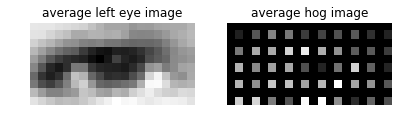

In [8]:
image_paths = fnmatch.filter(os.listdir('./face'), '*.jpg')

parts = read_facial_labels(image_paths)
lefteyes, righteyes, noses, mouths = parts

# Typical shape for left eye
lefteye_h = 10
lefteye_w = 20

lefteye_shape = (lefteye_h, lefteye_w)

avg_lefteye = get_detector(lefteye_h, lefteye_w, lefteyes, image_paths)
(lefteye_feature, lefteye_hog) = hog_feature(avg_lefteye, pixel_per_cell=2)

plt.subplot(1,3,1)
plt.imshow(avg_lefteye)
plt.axis('off')
plt.title('average left eye image')

plt.subplot(1,3,2)
plt.imshow(lefteye_hog)
plt.axis('off')
plt.title('average hog image')
plt.show()


Run through the following code to get a detector for right eye.

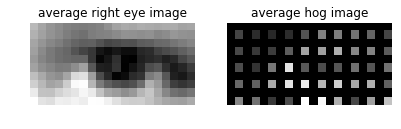

In [9]:
righteye_h = 10
righteye_w = 20

righteye_shape = (righteye_h, righteye_w)

avg_righteye = get_detector(righteye_h, righteye_w, righteyes, image_paths)

(righteye_feature, righteye_hog) = hog_feature(avg_righteye, pixel_per_cell=2)

plt.subplot(1,3,1)
plt.imshow(avg_righteye)
plt.axis('off')
plt.title('average right eye image')

plt.subplot(1,3,2)
plt.imshow(righteye_hog)
plt.axis('off')
plt.title('average hog image')
plt.show()

Run through the following code to get a detector for nose.

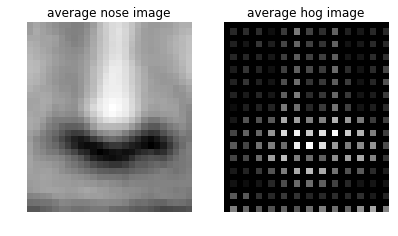

In [10]:
nose_h = 30
nose_w = 26

nose_shape = (nose_h, nose_w)

avg_nose = get_detector(nose_h, nose_w, noses, image_paths)

(nose_feature, nose_hog) = hog_feature(avg_nose, pixel_per_cell=2)

plt.subplot(1,3,1)
plt.imshow(avg_nose)
plt.axis('off')
plt.title('average nose image')

plt.subplot(1,3,2)
plt.imshow(nose_hog)
plt.axis('off')
plt.title('average hog image')
plt.show()

Run through the following code to get a detector for mouth

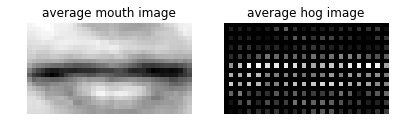

In [11]:
mouth_h = 20
mouth_w = 36

mouth_shape = (mouth_h, mouth_w)

avg_mouth = get_detector(mouth_h, mouth_w, mouths, image_paths)

(mouth_feature, mouth_hog) = hog_feature(avg_mouth, pixel_per_cell=2)

detectors_list = [lefteye_feature, righteye_feature, nose_feature, mouth_feature]

plt.subplot(1,3,1)
plt.imshow(avg_mouth)
plt.axis('off')
plt.title('average mouth image')

plt.subplot(1,3,2)
plt.imshow(mouth_hog)
plt.axis('off')
plt.title('average hog image')
plt.show()

# Part 5: Human Parts Location (10 points)

Implement **`compute_displacement`** to get an average shift vector mu and standard deviation sigma for each part of the face. The vector mu is the distance from the main center, i.e the center of the face, to the center of the part. <br>


In [12]:
# test for compute_displacement
test_array = np.array([[0,1],[1,2],[2,3],[3,4]])
test_shape = (6,6)
mu, std = compute_displacement(test_array, test_shape)
assert(np.all(mu == [1,0]))
assert(np.sum(std-[ 1.11803399,  1.11803399])<1e-5)
print("Your implementation is correct!")

Your implementation is correct!


In [13]:
lefteye_mu, lefteye_std = compute_displacement(lefteyes, face_shape)
righteye_mu, righteye_std = compute_displacement(righteyes, face_shape)
nose_mu, nose_std = compute_displacement(noses, face_shape)
mouth_mu, mouth_std = compute_displacement(mouths, face_shape)

After getting the shift vectors, we can run our detector on a test image. We will first run the following code to detect each part of left eye, right eye, nose and mouth in  the image. You will see a response map for each of them.

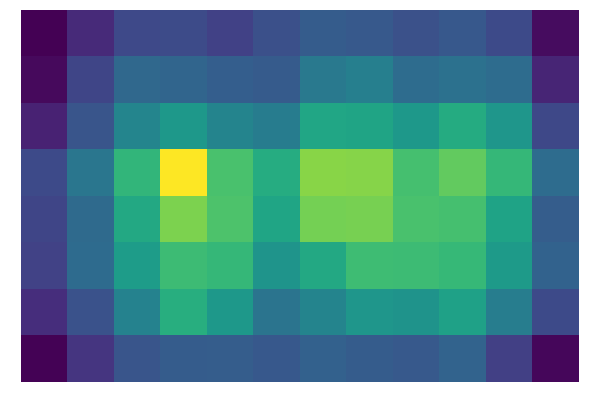

In [14]:
image_path = 'image_0338.jpg'
image = io.imread(image_path, as_grey=True)
image = rescale(image, 1.0)

(face_H, face_W) = face_shape
max_score, face_r, face_c, face_scale, face_response_map = pyramid_score\
    (image, face_feature, face_shape,stepSize = 30, scale=0.8)

plt.imshow(face_response_map, cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()

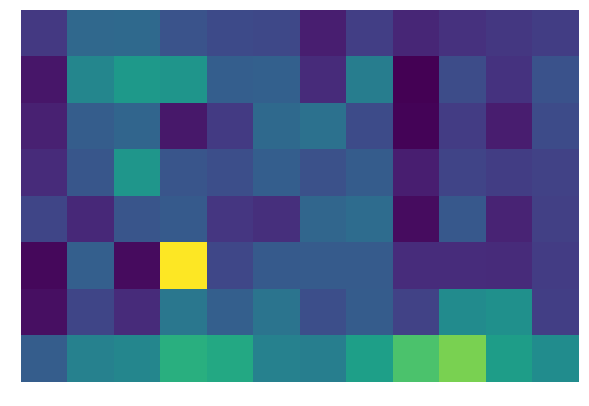

In [15]:
max_score, lefteye_r, lefteye_c, lefteye_scale, lefteye_response_map = \
    pyramid_score(image, lefteye_feature,lefteye_shape, stepSize = 20,scale=0.9, pixel_per_cell = 2)

lefteye_response_map = resize(lefteye_response_map, face_response_map.shape)

plt.imshow(lefteye_response_map,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()


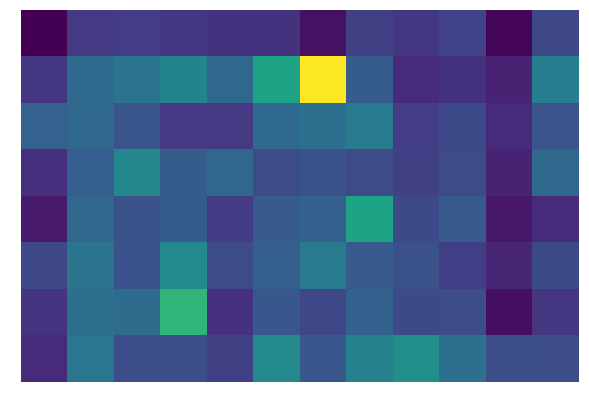

In [16]:
max_score, righteye_r, righteye_c, righteye_scale, righteye_response_map = \
    pyramid_score (image, righteye_feature, righteye_shape, stepSize = 20,scale=0.9, pixel_per_cell=2)

righteye_response_map = resize(righteye_response_map, face_response_map.shape)

plt.imshow(righteye_response_map,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()

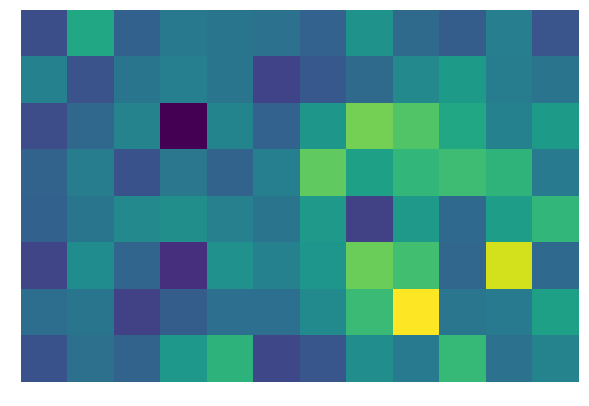

In [17]:
max_score, nose_r, nose_c, nose_scale, nose_response_map = \
    pyramid_score (image, nose_feature, nose_shape, stepSize = 20,scale=0.9, pixel_per_cell = 2)

nose_response_map = resize(nose_response_map, face_response_map.shape)

plt.imshow(nose_response_map,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()


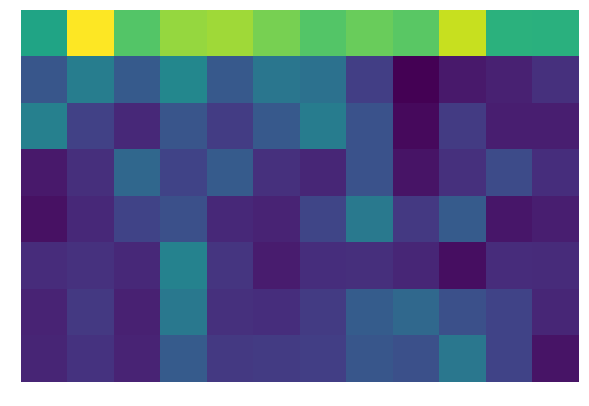

In [18]:
max_score, mouth_r, mouth_c, mouth_scale, mouth_response_map =\
    pyramid_score (image, mouth_feature, mouth_shape, stepSize = 20,scale=0.9, pixel_per_cell = 2)

mouth_response_map = resize(mouth_response_map, face_response_map.shape)
plt.imshow(mouth_response_map,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()


After getting the response maps for each part of the face, we will shift these maps so that they all have the same center as the face. We have calculated the shift vector mu in `compute_displacement`, so we are shifting based on vector mu. Implement `shift_heatmap` function in `detection.py`.

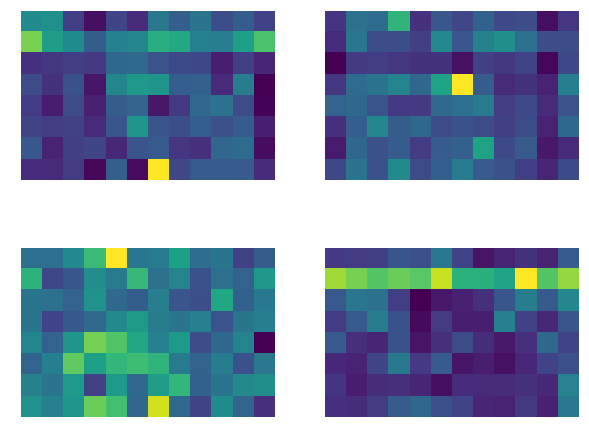

In [24]:
face_heatmap_shifted = shift_heatmap(face_response_map, [0,0])

lefteye_heatmap_shifted = shift_heatmap(lefteye_response_map, lefteye_mu)
righteye_heatmap_shifted = shift_heatmap(righteye_response_map, righteye_mu)
nose_heatmap_shifted = shift_heatmap(nose_response_map, nose_mu)
mouth_heatmap_shifted = shift_heatmap(mouth_response_map, mouth_mu)

f, axarr = plt.subplots(2,2)
axarr[0,0].axis('off')
axarr[0,1].axis('off')
axarr[1,0].axis('off')
axarr[1,1].axis('off')
axarr[0,0].imshow(lefteye_heatmap_shifted,cmap='viridis', interpolation='nearest')
axarr[0,1].imshow(righteye_heatmap_shifted,cmap='viridis', interpolation='nearest')
axarr[1,0].imshow(nose_heatmap_shifted,cmap='viridis', interpolation='nearest')
axarr[1,1].imshow(mouth_heatmap_shifted,cmap='viridis', interpolation='nearest')
plt.show()

# Part 6: Gaussian Filter (20 points)

## Part 6.1 Gaussian Filter
In this part, apply gaussian filter convolution to each heatmap. Blur by kernel of standard deviation sigma, and then add the heatmaps of the parts with the heatmap of the face. On the combined heatmap, find the maximum value and its location. You can use function provided by skimage to implement **`gaussian_heatmap`**.




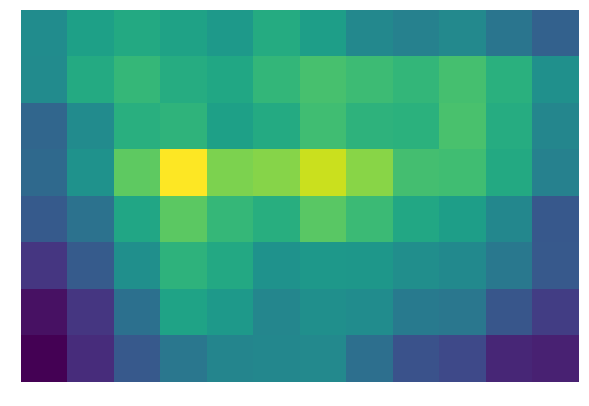

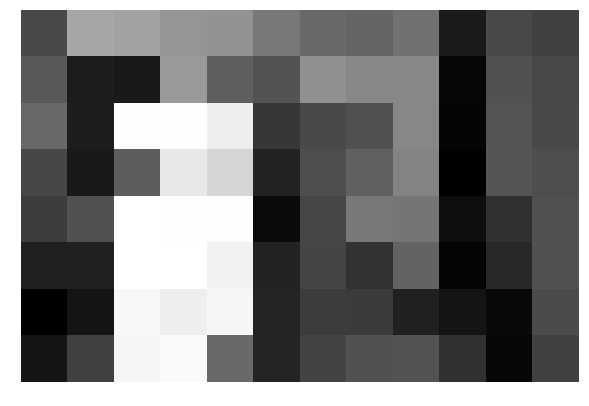

In [32]:
heatmap_face= face_heatmap_shifted

heatmaps = [lefteye_heatmap_shifted, 
           righteye_heatmap_shifted,
           nose_heatmap_shifted,
           mouth_heatmap_shifted]
sigmas = [lefteye_std, righteye_std, nose_std, mouth_std]

heatmap, i , j = gaussian_heatmap(heatmap_face, heatmaps, sigmas)

fig,ax = plt.subplots(1)
rect = patches.Rectangle((j-winW//2, i-winH//2),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.imshow(heatmap,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()

fig,ax = plt.subplots(1)
rect = patches.Rectangle((j-winW//2, i-winH//2),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.imshow(resize(image, heatmap.shape))
plt.axis('off')
plt.show()


## 6.2 Result Analysis (10 points)

Does your DPM work on detecting human faces? Can you think of a case where DPM may work better than the detector we had in part 3 (sliding window + image pyramid)? You can also have examples that are not faces.

**Your Answer:** Write your answer in this markdown cell.

## Extra Credit (1 point)
You have tried detecting one face from the image, and the next step is to extend it to detecting multiple occurences of the object. For example in the following image, how do you detect more than one face from your response map? Implement the function **`detect_multiple`**, and write code to visualize your detected faces in the cell below.

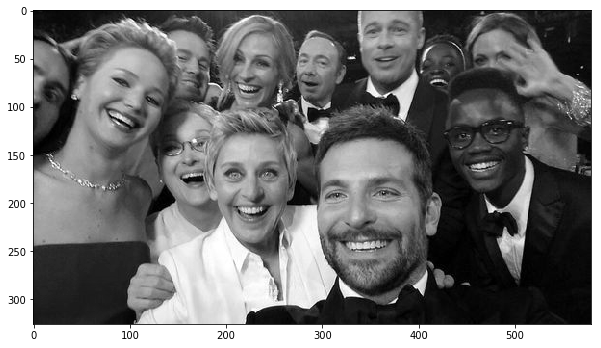

In [33]:
image_path = 'image_0002.jpg'
image = io.imread(image_path, as_grey=True)
plt.imshow(image)
plt.show()

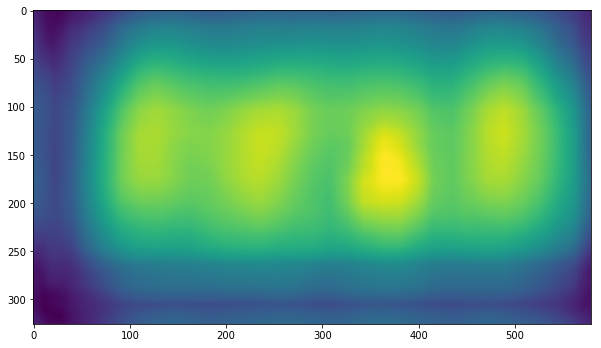

In [34]:
image_path = 'image_0002.jpg'
image = io.imread(image_path, as_grey=True)
heatmap = get_heatmap (image,face_feature, face_shape,detectors_list, parts )

plt.imshow(heatmap, cmap='viridis', interpolation='nearest')
plt.show()

In [35]:
detected_faces = detect_multiple(image, heatmap)

# Visualize your detected faces

### YOUR CODE HERE
pass
### END YOUR CODE

NameError: name 'detected_faces' is not defined